In [1]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
from sklearn import preprocessing
import numpy as np
import time
import os
from PIL import Image
import json
from pathlib import Path
import numpy as np
from sklearn.preprocessing import normalize
from datetime import datetime
import random
import matplotlib.pyplot as plt # plt 用於顯示圖片
import matplotlib.image as mpimg # mpimg 用於讀取圖片

In [2]:
# Replace with valid values
ENDPOINT = "https://stylervision.cognitiveservices.azure.com/"
training_key = "d7fb9c199bdb4c76952c6cb56b862b47"
prediction_key = "afbc2a74d69247429481db68cb64be3d"
prediction_resource_id = "/subscriptions/14bf462c-fe1a-47c2-a915-5cacdd27e7b1/resourceGroups/styler/providers/Microsoft.CognitiveServices/accounts/stylervision-Prediction"

In [3]:
credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(ENDPOINT, credentials)
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

In [4]:
publish_iteration_name = "detectModel-test"

# Find the object detection domain
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection" and domain.name == "General")

# Create a new project
print ("Creating project...")
project = trainer.create_project("Clothes Project", domain_id=obj_detection_domain.id)

Creating project...


In [5]:
# Make two tags in the new project
category_dict = { 1 :'short_sleeve_top', 2 :'long_sleeve_top', 3 :'short_sleeve_outwear', 4 :'long_sleeve_outwear', 
                  5 :'vest', 6 :'sling', 7 :'shorts', 8 :'trousers', 9 :'skirt', 10 :'short_sleeve_dress', 
                  11 :'long_sleeve_dress', 12 :'vest_dress', 13 :'sling_dress'}
regions_arr = [0] * 13
key_arr = [0] * 13
value_arr = [0] * 13
for i in range(1,14):
    category = category_dict.get(i)
    str_category = str(category)
    key_name = str_category + '_key'
    value_name = str_category + '_value'
    key_arr[i-1] = key_name
    value_arr[i-1] = value_name
    #tag_name = str_category + '_tag'
    #tag_name = trainer.create_tag(project.id, str_category)
    regions_name = str_category + '_regions'
    regions_arr[i-1] = regions_name
    #regions_name = {}
    
#這邊應該可以再優化
sling_dress_tag = trainer.create_tag(project.id, "sling dress") 
vest_dress_tag = trainer.create_tag(project.id, "vest dress")
short_sleeve_dress_tag = trainer.create_tag(project.id, "short sleeve dress")
sling_tag = trainer.create_tag(project.id, "sling")
vest_tag = trainer.create_tag(project.id, "vest")
long_sleeve_outwear_tag = trainer.create_tag(project.id, "long sleeve outwear")
short_sleeve_outwear_tag = trainer.create_tag(project.id, "short sleeve outwear")
long_sleeve_top_tag = trainer.create_tag(project.id, "long sleeve top")
long_sleeve_dress_tag = trainer.create_tag(project.id, "long sleeve dress")
short_sleeve_top_tag = trainer.create_tag(project.id, "short sleeve top")
skirt_tag = trainer.create_tag(project.id, "skirt")
shorts_tag = trainer.create_tag(project.id, "shorts")
trousers_tag = trainer.create_tag(project.id, "trousers")

In [6]:
#建一個資料夾 裡面放圖片跟json檔
base_location = 'C:/Users/JIALI/Desktop/project/VProject/train/image/'
#json_p = 'C:/Users/qingyu/Desktop/yutest/'
jList = os.listdir(base_location)

#這邊應該可以再優化
short_sleeve_top_regions = {}
long_sleeve_top_regions = {}
short_sleeve_outwear_regions = {}
long_sleeve_outwear_regions = {}
vest_regions = {}
sling_regions = {}
shorts_regions = {}
trousers_regions = {}
skirt_regions = {}
short_sleeve_dress_regions = {}
long_sleeve_dress_regions = {}
vest_dress_regions = {}
sling_dress_regions = {}

tag_num = 0

for file in jList:
    
    if file.endswith(".jpg"):
        img = Image.open( os.path.join(base_location,file))
        imgSize = img.size  #大小/尺寸
        pw = img.width       #图片的宽
        ph = img.height      #图片的高
        pf = img.format      #图像格式
     
        
# Region Left(rl) = X1 / Image Width
# Region Top(rt) = Y1 / Image Height
# Region Width(rw) = (X2 — X1) / image Width
# Region Height(rh)= (Y2 — Y1) / image Height
    
    if file.endswith(".json"):
        with open(os.path.join(base_location,file) , 'r') as reader:
            jf = json.loads(reader.read())
        strjf = str(jf)
        maxi = strjf.count('item') + 1
        for i in range (1,maxi):
            stri = str(i)
            category_id = jf['item'+stri]['category_id']
            category_name = category_dict.get(category_id)
            rl = jf['item'+stri]['bounding_box'][0]/pw
            rt = jf['item'+stri]['bounding_box'][1]/ph
            rw = (jf['item'+stri]['bounding_box'][2]-jf['item'+stri]['bounding_box'][0])/pw
            rh = (jf['item'+stri]['bounding_box'][3]-jf['item'+stri]['bounding_box'][1])/ph
            regions = category_name + '_regions'
            if regions in regions_arr:
                mydict = eval(regions)
                mydict[Path(file).stem]=[rl,rt,rw,rh,category_name]
                tag_num = tag_num + 1  
    if(tag_num>=200000):#因為在免費模式 要小於5000張
        break;

In [10]:
# Update this with the path to where you downloaded the images.
# Go through the data table above and create the images
print ("Adding images...")
total_count = 0
def upload():
    global total_count 
    count=0
    tagged_images_with_regions = []
    length = len(regions_arr)
    for i in range(0,length):
        key_arr[i] = list(eval(regions_arr[i]))
        value_arr[i] = list(eval(regions_arr[i]).values())
        for file_name in key_arr[i]:
            index = key_arr[i].index(file_name)
            x,y,w,h,c = value_arr[i][index]
            regions = c + '_regions'
            regions_dict = eval(regions)
            del regions_dict[file_name]
            key_arr[i] = list(regions_dict)
            value_arr[i] = list(regions_dict.values())
            tag = c + '_tag'
            regions = [ Region(tag_id=eval(tag).id, left=x,top=y,width=w,height=h) ] 
            count=count+1
            total_count = total_count+1
            with open(base_location  + file_name + ".jpg", mode="rb") as image_contents:
                tagged_images_with_regions.append(ImageFileCreateEntry(name=file_name, contents=image_contents.read(), regions=regions))
           
            if(count>=64):
                print("count",count)
                print("total_count",total_count)
                break
        else:
            continue
        break
                
            
    upload_result = trainer.create_images_from_files(project.id, ImageFileCreateBatch(images=tagged_images_with_regions))

    tagged_images_with_regions.clear()

    if not upload_result.is_batch_successful:
        print("Image batch upload failed.")
        for image in upload_result.images:
            print("Image status: ", image.status)
        exit(-1)
#end upload    

maxn = int(tag_num/64) + 1
for n in range (0,maxn): 
    upload()
    print(n)
#for n in range (0,maxn): upload()  


Adding images...
count 64
total_count 64
Image batch upload failed.
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimi

Image batch upload failed.
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  Err

Image batch upload failed.
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:

Image batch upload failed.
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:

Image batch upload failed.
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  Err

Image batch upload failed.
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  Err

Image batch upload failed.
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLim

Image batch upload failed.
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorL

Image batch upload failed.
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed

Image batch upload failed.
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:

Image batch upload failed.
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDupli

Image batch upload failed.
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDu

Image batch upload failed.
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  Er

Image batch upload failed.
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitEx

Image batch upload failed.
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status

Image batch upload failed.
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image statu

Image batch upload failed.
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status

Image batch upload failed.
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicat

Image batch upload failed.
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Ima

Image batch upload failed.
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image s

Image batch upload failed.
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Imag

Image batch upload failed.
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image stat

Image batch upload failed.
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  ErrorLimitExceed
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Image status:  OKDuplicate
Ima

CustomVisionErrorException: No valid image files

In [11]:
print (total_count)#281-16 10分鐘   #4792-11
t1 = time.time()
print (time.asctime( time.localtime(t1) ))
print ("Training...")

iteration = trainer.train_project(project.id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(60)
t2 = time.time()
print (time.asctime( time.localtime(t2) ))
print ("花費時間",str(round((t2-t1)/60,2)),"分鐘")

6866
Tue May 11 12:51:52 2021
Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Train

In [12]:
# The iteration is now trained. Publish it to the project endpoint
#trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, prediction_resource_id)

trainer.publish_iteration(project.id, iteration.id,publish_iteration_name ,  prediction_resource_id)

print ("Done!")

Done!


13clothes.jpg


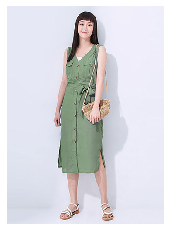

	skirt: 83.90% bbox.left = 0.32, bbox.top = 0.35, bbox.width = 0.31, bbox.height = 0.42
	vest: 82.71% bbox.left = 0.35, bbox.top = 0.17, bbox.width = 0.28, bbox.height = 0.26
	sling dress: 33.23% bbox.left = 0.31, bbox.top = 0.21, bbox.width = 0.32, bbox.height = 0.58
	vest dress: 11.48% bbox.left = 0.31, bbox.top = 0.16, bbox.width = 0.33, bbox.height = 0.60
	trousers: 3.65% bbox.left = 0.32, bbox.top = 0.36, bbox.width = 0.30, bbox.height = 0.41
	shorts: 3.21% bbox.left = 0.32, bbox.top = 0.36, bbox.width = 0.30, bbox.height = 0.41
	skirt: 0.67% bbox.left = 0.03, bbox.top = 0.30, bbox.width = 0.87, bbox.height = 0.51
	vest: 0.64% bbox.left = 0.31, bbox.top = 0.16, bbox.width = 0.33, bbox.height = 0.60
41clothes.jpg


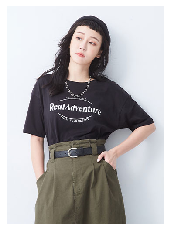

	short sleeve top: 92.96% bbox.left = 0.08, bbox.top = 0.30, bbox.width = 0.88, bbox.height = 0.36
	shorts: 41.29% bbox.left = 0.15, bbox.top = 0.62, bbox.width = 0.63, bbox.height = 0.38
	skirt: 28.88% bbox.left = 0.15, bbox.top = 0.62, bbox.width = 0.63, bbox.height = 0.38
	trousers: 19.55% bbox.left = 0.15, bbox.top = 0.62, bbox.width = 0.63, bbox.height = 0.38
	long sleeve top: 2.85% bbox.left = 0.10, bbox.top = 0.25, bbox.width = 0.85, bbox.height = 0.43
12clothes.jpg


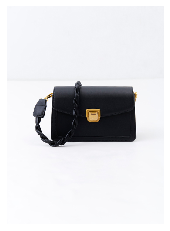

	skirt: 40.82% bbox.left = 0.19, bbox.top = 0.36, bbox.width = 0.67, bbox.height = 0.28
	trousers: 18.35% bbox.left = 0.14, bbox.top = 0.35, bbox.width = 0.69, bbox.height = 0.29
	shorts: 9.20% bbox.left = 0.19, bbox.top = 0.36, bbox.width = 0.67, bbox.height = 0.28
	vest: 4.98% bbox.left = 0.19, bbox.top = 0.36, bbox.width = 0.67, bbox.height = 0.28
	short sleeve top: 2.45% bbox.left = 0.14, bbox.top = 0.35, bbox.width = 0.69, bbox.height = 0.29
	long sleeve top: 1.48% bbox.left = 0.14, bbox.top = 0.35, bbox.width = 0.69, bbox.height = 0.29
	vest: 1.26% bbox.left = 0.09, bbox.top = 0.35, bbox.width = 0.90, bbox.height = 0.61
	skirt: 1.22% bbox.left = 0.10, bbox.top = 0.25, bbox.width = 0.87, bbox.height = 0.50
	long sleeve outwear: 0.84% bbox.left = 0.14, bbox.top = 0.35, bbox.width = 0.69, bbox.height = 0.29
	sling: 0.61% bbox.left = 0.19, bbox.top = 0.36, bbox.width = 0.67, bbox.height = 0.28
2clothes.jpg


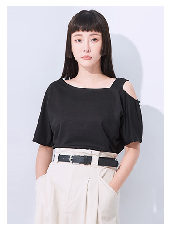

	short sleeve top: 89.46% bbox.left = 0.15, bbox.top = 0.32, bbox.width = 0.73, bbox.height = 0.38
	trousers: 64.98% bbox.left = 0.09, bbox.top = 0.65, bbox.width = 0.65, bbox.height = 0.35
	shorts: 44.36% bbox.left = 0.15, bbox.top = 0.64, bbox.width = 0.61, bbox.height = 0.35
	long sleeve top: 4.74% bbox.left = 0.13, bbox.top = 0.32, bbox.width = 0.72, bbox.height = 0.38
	skirt: 4.30% bbox.left = 0.15, bbox.top = 0.64, bbox.width = 0.61, bbox.height = 0.35
	short sleeve dress: 0.57% bbox.left = 0.08, bbox.top = 0.30, bbox.width = 0.80, bbox.height = 0.49
72clothes.jpg


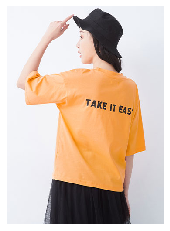

	short sleeve top: 88.52% bbox.left = 0.17, bbox.top = 0.28, bbox.width = 0.72, bbox.height = 0.61
	skirt: 79.75% bbox.left = 0.20, bbox.top = 0.73, bbox.width = 0.63, bbox.height = 0.27
	long sleeve top: 54.71% bbox.left = 0.12, bbox.top = 0.22, bbox.width = 0.81, bbox.height = 0.59
	shorts: 3.40% bbox.left = 0.17, bbox.top = 0.73, bbox.width = 0.63, bbox.height = 0.27
	trousers: 3.08% bbox.left = 0.17, bbox.top = 0.73, bbox.width = 0.63, bbox.height = 0.27
	vest: 1.58% bbox.left = 0.18, bbox.top = 0.05, bbox.width = 0.56, bbox.height = 0.28
	long sleeve outwear: 1.20% bbox.left = 0.08, bbox.top = 0.22, bbox.width = 0.82, bbox.height = 0.58
	short sleeve top: 1.06% bbox.left = 0.18, bbox.top = 0.05, bbox.width = 0.56, bbox.height = 0.28
	long sleeve dress: 0.70% bbox.left = 0.08, bbox.top = 0.22, bbox.width = 0.82, bbox.height = 0.58
	long sleeve top: 0.50% bbox.left = 0.18, bbox.top = 0.05, bbox.width = 0.56, bbox.height = 0.28
58clothes.jpg


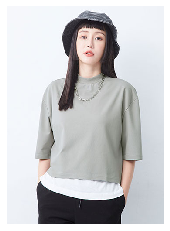

	long sleeve top: 95.68% bbox.left = 0.12, bbox.top = 0.29, bbox.width = 0.78, bbox.height = 0.61
	trousers: 83.50% bbox.left = 0.16, bbox.top = 0.74, bbox.width = 0.60, bbox.height = 0.26
	short sleeve top: 4.94% bbox.left = 0.17, bbox.top = 0.29, bbox.width = 0.83, bbox.height = 0.62
	shorts: 3.90% bbox.left = 0.16, bbox.top = 0.74, bbox.width = 0.60, bbox.height = 0.26
	long sleeve dress: 0.66% bbox.left = 0.10, bbox.top = 0.29, bbox.width = 0.78, bbox.height = 0.61
57clothes.jpg


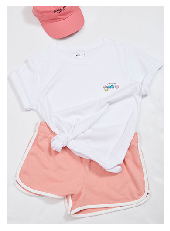

	short sleeve top: 79.76% bbox.left = 0.01, bbox.top = 0.14, bbox.width = 0.89, bbox.height = 0.62
	shorts: 77.58% bbox.left = 0.04, bbox.top = 0.47, bbox.width = 0.87, bbox.height = 0.50
	long sleeve top: 8.42% bbox.left = 0.09, bbox.top = 0.14, bbox.width = 0.90, bbox.height = 0.63
	shorts: 5.07% bbox.left = 0.01, bbox.top = 0.20, bbox.width = 0.90, bbox.height = 0.58
	shorts: 4.66% bbox.left = 0.04, bbox.top = 0.50, bbox.width = 0.44, bbox.height = 0.43
	skirt: 3.59% bbox.left = 0.09, bbox.top = 0.53, bbox.width = 0.88, bbox.height = 0.46
	short sleeve dress: 2.82% bbox.left = 0.01, bbox.top = 0.14, bbox.width = 0.89, bbox.height = 0.62
	vest: 2.55% bbox.left = 0.00, bbox.top = 0.15, bbox.width = 0.83, bbox.height = 0.60
	short sleeve top: 2.33% bbox.left = 0.04, bbox.top = 0.50, bbox.width = 0.44, bbox.height = 0.43
	skirt: 2.28% bbox.left = 0.04, bbox.top = 0.50, bbox.width = 0.44, bbox.height = 0.43
	trousers: 1.74% bbox.left = 0.03, bbox.top = 0.51, bbox.width = 0.88, bbox.heigh

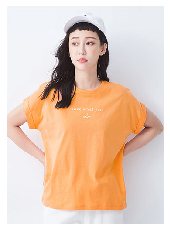

	short sleeve top: 91.55% bbox.left = 0.04, bbox.top = 0.31, bbox.width = 0.87, bbox.height = 0.63
	trousers: 24.27% bbox.left = 0.19, bbox.top = 0.75, bbox.width = 0.57, bbox.height = 0.24
	shorts: 14.83% bbox.left = 0.18, bbox.top = 0.85, bbox.width = 0.59, bbox.height = 0.15
	skirt: 6.35% bbox.left = 0.18, bbox.top = 0.85, bbox.width = 0.59, bbox.height = 0.15
	vest: 5.72% bbox.left = 0.00, bbox.top = 0.30, bbox.width = 0.83, bbox.height = 0.62
	shorts: 5.45% bbox.left = 0.17, bbox.top = 0.93, bbox.width = 0.62, bbox.height = 0.07
	trousers: 3.13% bbox.left = 0.17, bbox.top = 0.93, bbox.width = 0.62, bbox.height = 0.07
	long sleeve top: 2.58% bbox.left = 0.18, bbox.top = 0.34, bbox.width = 0.81, bbox.height = 0.63
	skirt: 2.21% bbox.left = 0.17, bbox.top = 0.93, bbox.width = 0.62, bbox.height = 0.07
	short sleeve dress: 1.54% bbox.left = 0.18, bbox.top = 0.34, bbox.width = 0.81, bbox.height = 0.63
	trousers: 0.59% bbox.left = 0.31, bbox.top = 0.86, bbox.width = 0.42, bbox.height = 0

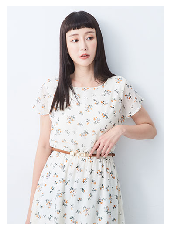

	short sleeve top: 96.07% bbox.left = 0.18, bbox.top = 0.29, bbox.width = 0.72, bbox.height = 0.41
	skirt: 77.04% bbox.left = 0.14, bbox.top = 0.64, bbox.width = 0.62, bbox.height = 0.36
	shorts: 15.43% bbox.left = 0.14, bbox.top = 0.69, bbox.width = 0.62, bbox.height = 0.31
	vest: 4.27% bbox.left = 0.25, bbox.top = 0.30, bbox.width = 0.66, bbox.height = 0.40
	trousers: 1.58% bbox.left = 0.14, bbox.top = 0.69, bbox.width = 0.62, bbox.height = 0.31


In [15]:
# Now there is a trained endpoint that can be used to make a prediction

# Open the sample image and get back the prediction results.
test_path ="C:/Users/JIALI/Desktop/nuv/"
   
def quicktest():
    
    #img = str(random.randint(0,9999)).zfill(6)+".jpg"
    img = str(random.randint(2,76))+"clothes.jpg"
    lena = mpimg.imread(test_path+img)
    plt.imshow(lena)
    plt.axis('off') # 不顯示座標軸
    print(img)
    plt.show()
    with open(test_path+img, mode="rb") as test_data:
        results = predictor.detect_image(project.id, publish_iteration_name, test_data)
   
    
# Display the results.    
    for prediction in results.predictions:
        print("\t" + prediction.tag_name + ": {0:.2f}% bbox.left = {1:.2f}, bbox.top = {2:.2f}, bbox.width = {3:.2f}, bbox.height = {4:.2f}".format(prediction.probability * 100, prediction.bounding_box.left, prediction.bounding_box.top, prediction.bounding_box.width, prediction.bounding_box.height))

for i in range(1,10):
    quicktest()